In [451]:
import pytorch_lightning as pl
from matplotlib import pyplot as plt
import seaborn as sns
from cca_zoo.deepmodels import (
    DCCA,
    DCCA_NOI,
    DCCA_SDL,
    BarlowTwins,
    get_dataloaders,
    
)
from cca_zoo.deepmodels.utils import architectures, objectives
from cca_zoo.plotting import pairplot_label
from cca_zoo.data import CCA_Dataset
from cca_zoo.models import CCA
import torch.optim as optim
from sklearn.model_selection import train_test_split
import os
from scipy.spatial import distance
from scipy.stats import pearsonr
import random
import pandas as pd
import numpy as np
import pickle


os.chdir('../raw_data')


#### Functions to load and or write to pickle files

In [452]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

In [453]:
# load df with all info
path = './df_classes_max3_embeddings.pickle'
df_all = Files(path).load_pickle()#[:20000] #just a subset for scripting
df_all.shape

(41447, 8)

In [454]:
# # #drop inchikeys appering once, to make it possible to stratify based on inchikey
# df_all = df_all.groupby('cf_class').filter(lambda x : len(x)>=2)
# df_all.shape

In [608]:
#split into train and test dataset
train_df, test_df = \
train_test_split(df_all, test_size=0.2, random_state=42)#, stratify=df_all['cf_class'])

#Split train dataset into train and validation set
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=42)


#extract the 2 view, v1 == spectra embeddings, v2==structure embeddings
v1_train, v1_test = np.array([x for x in train_df['ms2ds']]), np.array([x for x in test_df['ms2ds']])
v2_train, v2_test = np.array([x for x in train_df['mol2vec']]), np.array([x for x in test_df['mol2vec']])

# validation
v1_val, v2_val = np.array([x for x in val_df['ms2ds']]), np.array([x for x in val_df['mol2vec']])

In [609]:
# What does CCA dataset do????
train_dataset = CCA_Dataset([v1_train, v2_train])
test_dataset = CCA_Dataset([v1_test, v2_test])
val_dataset = CCA_Dataset([v1_val, v2_val])
batch_size = 700
train_loader , val_loader = get_dataloaders(train_dataset, \
                                            val_dataset,batch_size=batch_size,\
                                            num_workers=6,drop_last=False)
test_loader = get_dataloaders(test_dataset,\
                              batch_size=batch_size, \
                              num_workers=6,drop_last=False)

In [591]:



#code is still a mess: STRUCTURE!!!
#params
N = len(train_dataset)
latent_dims = 50
epochs = v2_train.shape[1]
lr = 0.001
#optimizer = optim.SGD(lr=0.01, momentum=0.9)


print('\n','-'*20,'\n Training CCA\n','-'*20)
cca = CCA(latent_dims=latent_dims).fit((v1_train, v2_train))# train cca as well for comparison

# define encoders
encoder_1 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v1_train.shape[1],\
                                  layer_sizes=(128,)
                                )
                                     
encoder_2 = architectures.Encoder(latent_dims=latent_dims, \
                                  feature_size=v2_train.shape[1], \
                                  layer_sizes=(128,)
                                 )



 -------------------- 
 Training CCA
 --------------------


In [592]:
#extract cca correlation
cca_train_corr = cca.score([v1_train, v2_train])
cca_test_corr = cca.score([v1_test, v2_test])

In [617]:
# generate cca train projections
train_cca_z1, train_cca_z2 = cca.transform([v1_train, v2_train])
train_df['cca_z1'] = [x for x in train_cca_z1]
train_df['cca_z2'] = [x for x in train_cca_z2]

In [618]:
# generate cca test projections
test_cca_z1, test_cca_z2 = cca.transform([v1_test, v2_test])
test_df['cca_z1'] = [x for x in test_cca_z1]
test_df['cca_z2'] = [x for x in test_cca_z2]

In [619]:
# generate cca val projections
val_cca_z1, val_cca_z2 = cca.transform([v1_val, v2_val])
val_df['cca_z1'] = [x for x in val_cca_z1]
val_df['cca_z2'] = [x for x in val_cca_z2]

In [596]:
%%time
#  # 1. DCCA
dcca = DCCA(
        latent_dims=latent_dims,
        encoders=[encoder_1, encoder_2],
        objective=objectives.CCA,
        optimizer='sgd',
        lr=lr)

 # Define the trainer
#dcca
trainer = pl.Trainer(
        max_epochs=epochs, log_every_n_steps=1)#,\
        #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="val/objective")])

#train
print('\n','-'*20,'\n Training DCCA\n','-'*20)
trainer.fit(dcca, train_loader,val_loader)

#score
dcca_train_corr = dcca.score(train_loader)
dcca_test_corr = dcca.score(test_loader)


# generate dcca train projections
train_loader, val_loader  = get_dataloaders(train_dataset,val_dataset,batch_size=batch_size)
                                            
train_z1, train_z2 = dcca.transform(train_loader)
train_df['dcca_z1'] = [x for x in train_z1]
train_df['dcca_z2'] = [x for x in train_z2]

# generate dcca test projections
test_loader = get_dataloaders(test_dataset,batch_size=batch_size)#,batch_size=batch_size)
test_z1, test_z2 = dcca.transform(test_loader)
test_df['dcca_z1'] = [x for x in test_z1]
test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = dcca.transform(val_loader)
val_df['dcca_z1'] = [x for x in val_z1]
val_df['dcca_z2'] = [x for x in val_z2]

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name     | Type       | Params
----------------------------------------
0 | encoders | ModuleList | 77.2 K
----------------------------------------
77.2 K    Trainable params
0         Non-trainable params
77.2 K    Total params
0.309     Total estimated model params size (MB)



 -------------------- 
 Training DCCA
 --------------------


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

ValueError: Length of values (29400) does not match length of index (29841)

In [615]:
# generate dcca train projections
train_loader, val_loader  = get_dataloaders(train_dataset,val_dataset,\
                                            batch_size=batch_size,drop_last=False)
                                            
train_z1, train_z2 = dcca.transform(train_loader)
train_df['dcca_z1'] = [x for x in train_z1]
train_df['dcca_z2'] = [x for x in train_z2]

# generate dcca test projections
test_loader = get_dataloaders(test_dataset,batch_size=batch_size,drop_last=False)#,batch_size=batch_size)
test_z1, test_z2 = dcca.transform(test_loader)
test_df['dcca_z1'] = [x for x in test_z1]
test_df['dcca_z2'] = [x for x in test_z2]

# generate dcca val projections
#val_loader = get_dataloaders(batch_size=batch_size)
val_z1, val_z2 = dcca.transform(val_loader)
val_df['dcca_z1'] = [x for x in val_z1]
val_df['dcca_z2'] = [x for x in val_z2]

In [616]:
test_df.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,dcca_z1,dcca_z2
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.019595183, 0.64670193, 0.9301924, 0.6984255...","[0.62897867, 0.26106036, -0.96975267, -0.91250..."
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[0.36203933, -0.55139923, 1.60649, 1.0591184, ...","[0.28765213, 0.03144324, -1.1431564, -1.178904..."
32710,O=C2C(O)=C(OC=3C=C(OC1OC(CO)C(O)C(O)C1(O))C(OC...,AFCDXKGLUDDXCK-UHFFFAOYSA-N,AFCDXKGLUDDXCK,spec_id31385,"[4.156373062713153, 2.6467714749778737, -9.709...","[25.13886260986328, 20.056901931762695, 0.0, 0...","[3.884097, -4.328525, -8.565995, 3.9552908, 1....",Flavonoids,"[0.8276999, 2.6555135, 4.2343054, -1.0716201, ...","[-0.39700013, 0.26591673, -0.78599775, -1.4591..."
14421,C1OC2=C(O1)C=C(C=C2)C3=COC4=C(C3=O)C=CC(=C4)O,KNJNBKINYHZUGC-UHFFFAOYSA-N,KNJNBKINYHZUGC,spec_id12744,"[-2.8919476279177254, 7.136436073237354, -11.3...","[0.0, 10.869701385498047, 0.0, 0.9871315956115...","[1.584554, -2.3259673, -3.662932, 4.6133733, -...",Isoflavonoids,"[-0.15958497, 0.45548752, 1.4036384, 1.5527513...","[0.23975137, 0.012886554, -0.9098065, -0.85514..."
24733,O=C(OC1C(OC(OCCC2=CC=C(O)C(O)=C2)C(OC(=O)C)C1O...,ALERZNQPBWWLMW-UHFFFAOYSA-N,ALERZNQPBWWLMW,spec_id23060,"[-4.41229641164563, -6.063199486461368, 5.2722...","[2.8529367446899414, 9.61679458618164, 15.8730...","[1.791454, -10.160973, -14.062275, 4.4526644, ...",Cinnamic acids and derivatives,"[-0.8694132, 1.5257906, 0.8202249, 0.72354436,...","[-0.30828398, 1.5934219, -0.25062895, -1.79586..."


In [302]:
# %%time
# # 2. SDL
# sdl = DCCA_SDL(latent_dims,optimizer='sgd',
#                 N=N, encoders=[encoder_1, encoder_2],
#                 lam=0.0001, lr=lr,
#                 objective=objectives.CCA,) # train size

# #train
# trainer_sdl = pl.Trainer(
#         max_epochs=epochs, log_every_n_steps=1)#,
        
#         #callbacks=[pl.callbacks.early_stopping.EarlyStopping(monitor="train/sdl")])# early stopage to reduce overfitting

# print('\n','-'*20,'\n Training SDL\n','-'*20)
# sdl=trainer_sdl.fit(sdl, train_loader,val_loader)

In [580]:
dcca_test_corr

array([0.8746447 , 0.80445656, 0.7948514 , 0.74280941, 0.73129004,
       0.72495707, 0.66707086, 0.62250926, 0.59757914, 0.58272981,
       0.55632831, 0.53294372, 0.50966125, 0.50024502, 0.47858734,
       0.47347117, 0.43943047, 0.42933444, 0.42282235, 0.40789916,
       0.39498467, 0.36591077, 0.36198178, 0.33830387, 0.32648844,
       0.31658106, 0.30467535, 0.28996237, 0.28386047, 0.26264961,
       0.25645078, 0.24767461, 0.23048322, 0.22167875, 0.21226858,
       0.20163676, 0.19845507, 0.18534124, 0.18205192, 0.17057704,
       0.15172536, 0.14242079, 0.13129034, 0.11564607, 0.09647026,
       0.08999137, 0.08569631, 0.08063481, 0.06917966, 0.05097345])

In [304]:

# sdl_train_corr = sdl.score(train_loader)
# sdl_train_corr[0:5]

In [ ]:
#array([0.96825956, 0.95638675, 0.95365948, 0.94538253, 0.94008649])
#array([0.96109012, 0.92829286, 0.91989456, 0.89615484, 0.89071668])

In [272]:
# sdl_test_corr = sdl.score(test_loader)
# sdl_test_corr[0:5]

array([0.93315397, 0.89833364, 0.86018579, 0.84250586, 0.80810776])

In [105]:
embedding = 'MS2DeepScore'
method = 'ALL_3_hidden'
data = 'max3_stratified'
dims = latent_dims

In [106]:
#sns.color_palette("colorblind")

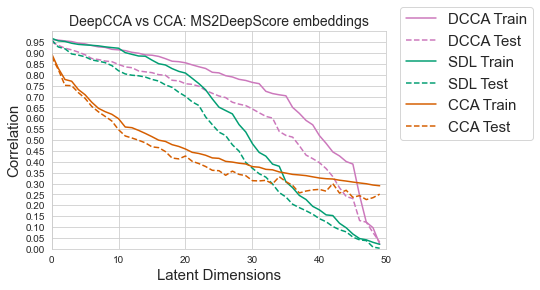

In [107]:
# plot train correlation vs test correlation
x=[x for x in range(latent_dims)]
fig, ax = plt.subplots()

sns.set_style('whitegrid')

line = ['solid', 'dashed']

#justice for the color blind :)
palette = [sns.color_palette("colorblind")[4],\
           sns.color_palette("colorblind")[2],\
           sns.color_palette("colorblind")[3]] 

dfs = [[dcca_train_corr, dcca_test_corr],\
       [sdl_train_corr, sdl_test_corr],\
       [cca_train_corr,cca_test_corr]]

for i, df in enumerate(dfs):
    #train
    sns.lineplot(x=x,y=df[0], \
                 color = palette[i],
                 linestyle=line[0],ax=ax)
    #test
    sns.lineplot(x=x,y=df[1],\
                 color = palette[i],
                 linestyle=line[1], ax=ax)

    plt.legend(labels=['DCCA Train', 'DCCA Test',\
                  'SDL Train', 'SDL Test',\
                  'CCA Train', 'CCA Test'], \
                   loc=(1.04, 0.5),\
                    fontsize=15)#title='Algorithm', 
plt.xlabel('Latent Dimensions', fontsize=15)
plt.ylabel('Correlation', fontsize=15)
plt.ylim(0, 1.0)
plt.title(label=f'DeepCCA vs CCA: {embedding} embeddings',\
          fontsize=14,loc='center')
plt.xlim(0, latent_dims)

plt.yticks(np.arange(0, 1, step=0.05))
plt.savefig(f'../plots/{method}_{data}_{dims}_vs_cca_{embedding}.png',\
           transparent=False,bbox_inches = 'tight')
plt.show()

### Assess Prediction Performance: DCCA

##### Predict Structure from spectra Embeddings

1. Calculate:

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [506]:
def predict(subject_df,query_df,\
            method,dims,metric='euc'): #both dfs should have z1 and z2 coloumns

    preds = {}
    
    for query_index, query in enumerate(query_df[f'{method}_z1']): #(query z1)
        
        #query = query_df.loc[query_index,'z1']
        preds[query_index] = []
        for subject in subject_df[f'{method}_z2']:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                preds[query_index].append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                preds[query_index].append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                preds[query_index].append(cos)
    # you might want to sort preds and return only top hits for better memory
    return preds
    

In [14]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm

In [15]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [570]:
def get_tanimotos(preditions_dict,\
                  subject_df,query_df, metric,random_=False):
    tanimotos = []
    for query_index, values in preditions_dict.items(): # values == score(corr, euc or cosine)
        
        #select top 5 hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:5] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            for hit in top_hits:
                if random_:#test with random: picks random subject index
                    
                    random_value = random.sample(values,1)
                    subject_index = values.index(random_value)
                
                else:# picks true hits index
                    subject_index = values.index(hit)
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
        #select closest 5 hits for each query based on cosine/euclidian distance
        else:
            top_hits = np.sort(values)[:5] #if its euc or cos; the lower the better
    
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            for hit in top_hits:
        
                subject_index = values.index(hit)
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                top_hits_scores.append(tanimoto(smile1,smile2))
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
    return tanimotos
    

In [ ]:
%%time
#predict euc
test_dcca_corr = predict(subject_df=train_df,\
                        query_df=test_df.head(50),dims=50,\
                        method='dcca', metric='corr')

In [ ]:
test_cca_corr = predict(subject_df=train_df,\
                       query_df=test_df.head(50),dims=50,\
                       method='cca',metric='corr')

In [ ]:
# %%time
# #predict euc
# test_dcca_euc =  predict(subject_df=train_df,\
#                         query_df=test_df.head(50),dims=50,\
#                         method='dcca', metric='corr')

In [ ]:
len(val_cca_corr.keys())

In [ ]:
%%time
#calculate  Validation tanimotos 
    
    
test_dcca_corr_tanimotos = get_tanimotos(test_dcca_corr, \
                                       subject_df=train_df,\
                                        query_df=test_df.head(50),\
                                        metric='corr')

In [ ]:
%%time
#calculate  Validation Euclidean tanimotos 
    
    
test_cca_corr_tanimotos = get_tanimotos(test_cca_corr, \
                                       subject_df=train_df,\
                                       query_df=test_df.head(50), \
                                       metric='corr')

In [ ]:
random_tanimoto = get_tanimotos(test_dcca_corr, \
                                       subject_df=train_df,\
                                       query_df=test_df.head(50), \
                                       metric='corr', random_=True)

In [ ]:
#plot the distribution of the three top tanimotos from the three metrics
dist_list = [test_cca_corr_tanimotos,
             test_dcca_corr_tanimotos,
            random_tanimoto]
for dist in dist_list:
    ax=sns.kdeplot(x=dist,shade=True)
plt.legend(labels=['CCA','DCCA', 'Random'], loc='upper right', fontsize=12)
plt.xlabel('Tanimoto score', fontsize=15)
plt.ylabel('Density', fontsize=15)
plt.title(label='Tanimoto score Distribution', fontsize=15)
plt.show()

#### Draw Random predicted molecule

In [440]:
from rdkit import Chem
from rdkit.Chem import Draw

In [551]:

keys = random.sample(test_cca_corr.keys(),5)
sample_dict = {key: test_cca_corr[key] for key in keys}

C:\Users\lmeli\AppData\Local\Temp/ipykernel_12808/3223648008.py:1: DeprecationWarning: Sampling from a set deprecated
since Python 3.9 and will be removed in a subsequent version.
  keys = random.sample(test_cca_corr.keys(),5)


In [559]:
for key, values in sample_dict.items():
    print(key,max(values))
    print(np.sort(values)[::-1][0:5])

28 0.644278148805333
[0.64427815 0.64427815 0.64427815 0.6147927  0.61004189]
19 0.7656659522149415
[0.76566595 0.76566595 0.76139165 0.76139165 0.74771674]
20 0.4836656753432612
[0.48366568 0.48366568 0.48366568 0.48065952 0.47654358]
40 0.6586968733645517
[0.65869687 0.6403741  0.6403741  0.6403741  0.61395223]
6 0.6330917890785959
[0.63309179 0.62845221 0.62845221 0.62845221 0.62790479]


In [560]:

all_mols = []
#scores = []
mol_classes = []
#os.chdir('../compounds')
for query_index, values in tqdm(sample_dict.items()):
    top_hits = np.sort(values)[::-1][:5]
    tanimotos = []
    
    #draw the query
    
    query_smile= val_df['smiles'].iloc[query_index]
    query_class = val_df['cf_class'].iloc[query_index]
    if type(query_class) == float:
        query_class = 'NAN'
        classes = [f'Query:\t{query_class}',]
    classes = [f'QUERY:\t{query_class}',]
    query = Chem.MolFromSmiles(query_smile)
    #Draw.MolToFile(query, f"dcca_max_corr_query_{query_index}_{query_class}.png")
    #Draw.MolsToGridImage(query)
    #draw top 5 hits
    subjects = [query,]
    for hit_index, hit in enumerate(top_hits):
        subject_index = values.index(hit)
        subject_smile = train_df['smiles'].iloc[subject_index]
        
        
        subject = Chem.MolFromSmiles(subject_smile)
        subjects.append(subject)
        #Draw.MolToFile(subject, f"dcca_max_corr_query_{query_index}_hit_{hit_index}_{subject_class}.png")
        cl = train_df['cf_class'].iloc[subject_index]
        if type(cl) == float:
            cl = 'NAN'
            subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
            classes.append(subject_class)
        else:
            subject_class = f'\tHit_{hit_index}\t{cl}:\nTanimoto:\t{tanimoto(query_smile,subject_smile)}'
            classes.append(subject_class)
        #check tanimotos for the random selections
        tanimotos.append(tanimoto(query_smile,subject_smile))
   # scores.append([(query_index,query_class),tanimotos])
    all_mols.append(subjects)
    mol_classes.append(classes)



100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.80it/s]


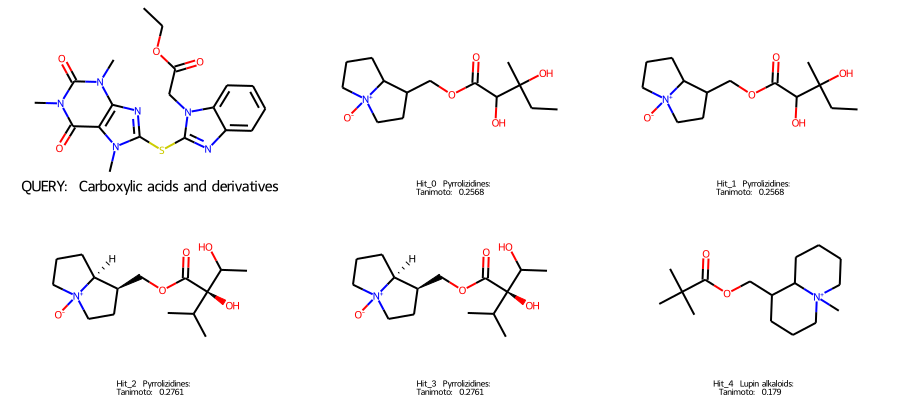

In [561]:
#draw the molecule
query=2
Draw.MolsToGridImage([all_mols[query][i] for i in range(len(all_mols[query]))],
                         molsPerRow=3, 
                     legends = mol_classes[query],
                    subImgSize=(300,200))


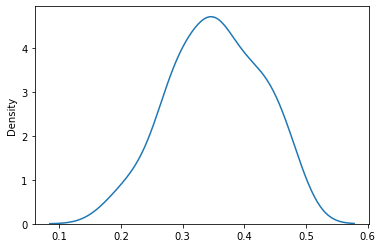

In [470]:
#just to see the highest corr attained
corr = []
for query_index, values in val_dcca_corr.items():
    corr.append(max(values))
    
ax=sns.kdeplot(x=corr,shade=False)